## Importing libraries and dependencies

In [0]:
from __future__ import print_function
import time
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
#from scipy.misc import imsave

Using TensorFlow backend.


In [0]:
!ls

sample_data  src4.jpg  style2.jpg  style.jpg


In [0]:
from google.colab import files
files.upload()


Saving style4.jpg to style4.jpg


{'style4.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc2\x00\x11\x08\x04\xb0\x07?\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x01\x02\x03\x04\x06\x00\x07\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x00\x04\x05\x06\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xc8\xb5\xf1\',R\'\x0c\xbc\xee3z*\x95W\xb5\xcc\x88\xd7#\x94N\xed\x95\x8d\xac\xb4\xbbEi\xe7-J\xc0\xf3\xa7!\x0c\xdah\xe8e\xa2tS\x07V\xe2c\x8a-9Y\x13Bt\xe5\xc1\x1c\x8a\xc1y\xaaG9\xa8\xc1{\x9awr\xa0<\xa9\xc39\xaea\xdc\xbd\xdbr/\x0c\xd6\xc8\xc0S\x95\xc

## Loading content & style images

In [0]:
content_image=Image.open('src4.jpg')
content_image=content_image.resize((512,512))

style_image=Image.open('style4.jpg')
style_image=style_image.resize((512,512))

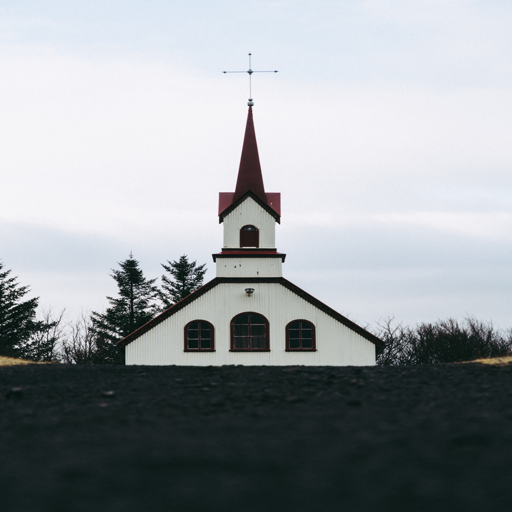

In [0]:
content_image

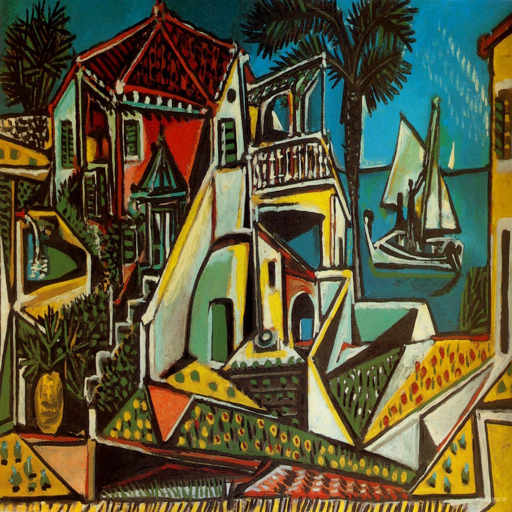

In [0]:
style_image

## Converting image into array

In [0]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)

style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)

## Making the images suitable for *VGG Network*

In [0]:
# subtracting mean RGB values
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68

# RGB -> BGR
content_array = content_array[:, :, :, ::-1]

# subtracting mean RGB values
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68

# RGB -> BGR
style_array = style_array[:, :, :, ::-1]

## Concatenate image data into a tensor

In [0]:
height=512
width=512

content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## Loading the model

In [0]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

## Naming the layers

In [0]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 64, 64, 51

## Assigning relative importance to the images

In [0]:
content_weight = 0.05 # in some cases I used 1
style_weight = 5.0    #in some cases I used 10
total_variation_weight = 1.0

## Initializing loss as 0

In [0]:
loss = backend.variable(0.)

## Content loss

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
# bug fix here no shorthand is allowed
loss=loss+(content_weight * content_loss(content_image_features, combination_features))

## Style loss

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss=loss+((style_weight / len(feature_layers)) * sl)

## Total variation loss 

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss=loss+(total_variation_weight * total_variation_loss(combination_image))

## Solving the optimization problem

In [0]:
grads = backend.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

## Using LBFGS algorithm

In [0]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 173331630000.0
Iteration 0 completed in 7s
Start of iteration 1
Current loss value: 120032270000.0
Iteration 1 completed in 7s
Start of iteration 2
Current loss value: 97727800000.0
Iteration 2 completed in 7s
Start of iteration 3
Current loss value: 89953040000.0
Iteration 3 completed in 7s
Start of iteration 4
Current loss value: 85793510000.0
Iteration 4 completed in 7s
Start of iteration 5
Current loss value: 84168670000.0
Iteration 5 completed in 7s
Start of iteration 6
Current loss value: 83362030000.0
Iteration 6 completed in 7s
Start of iteration 7
Current loss value: 82872000000.0
Iteration 7 completed in 7s
Start of iteration 8
Current loss value: 82551500000.0
Iteration 8 completed in 7s
Start of iteration 9
Current loss value: 82335390000.0
Iteration 9 completed in 7s


## Convert array to image and show output

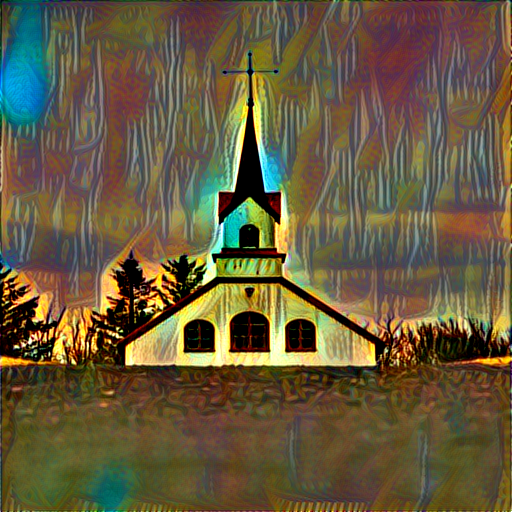

In [0]:

x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')
Image.fromarray(x)